In [2]:
# Imports and logging configuration
import logging
from pathlib import Path
from typing import Tuple, Union, Optional, Dict, Any

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import logging
from pathlib import Path
from typing import Tuple, Union, Optional, Dict, Any

import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from prophet import Prophet
import pmdarima as pm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Configuring the logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [114]:
# Section 2: Load Data
def load_data(filepath: Union[str, Path]) -> Optional[pd.DataFrame]:
    """Load stock data from a CSV file."""
    try:
        data = pd.read_csv(filepath)
        data['date'] = pd.to_datetime(data['date'])
        required_columns = {'date', 'open', 'high', 'low', 'close', 'volume', 'Name'}
        missing_columns = required_columns - set(data.columns)
        if missing_columns:
            raise ValueError(f"Missing columns: {missing_columns}")
        logger.info("Data loaded successfully.")
        return data
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return None

filepath = 'all_stocks_5yr.csv'
data = load_data(filepath)
data.head()


2024-05-18 13:01:40,625 - INFO - Data loaded successfully.


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


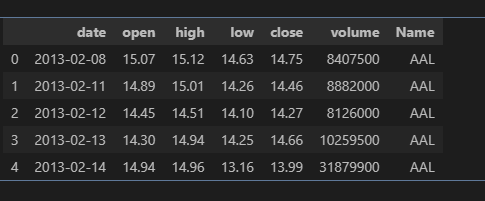

In [121]:
# Data Exploration
def explore_data(data: pd.DataFrame) -> pd.DataFrame:
    """Explore the data and log it"""
    exploration_report = []
    for col in data.columns:
        col_type = data[col].dtype
        missing_persentage = data[col].isnull().mean() * 100
        unique_values = data[col].nunique()
        outliers = [(np.abs(stats.zscore(data[col])) > 3).sum()] if np.issubdtype(data[col].dtype, np.number) else None
        exploration_report.append ({
            'column': col,
            'type': col_type,
            'missing_values': missing_persentage,
            'unique_values': unique_values,
            'outliers': outliers
        })

        logger.info(f"FEATURE: {col}, TYPE: {col_type}, MISSING: {missing_persentage:.2F}%, UNIQUE: {unique_values}, OUTLIERS: {outliers}")
    exploration = pd.DataFrame(exploration_report)
    logger.info(f"Exploration Report :\n{exploration}") 
exploration_report = explore_data(data)
exploration_report

2024-05-18 13:09:55,955 - INFO - FEATURE: open, TYPE: float64, MISSING: 0.00%, UNIQUE: 49715, OUTLIERS: [0]
2024-05-18 13:09:55,983 - INFO - FEATURE: high, TYPE: float64, MISSING: 0.00%, UNIQUE: 81499, OUTLIERS: [0]
2024-05-18 13:09:56,012 - INFO - FEATURE: low, TYPE: float64, MISSING: 0.00%, UNIQUE: 82354, OUTLIERS: [0]
2024-05-18 13:09:56,041 - INFO - FEATURE: close, TYPE: float64, MISSING: 0.00%, UNIQUE: 51151, OUTLIERS: [8508]
2024-05-18 13:09:56,085 - INFO - FEATURE: volume, TYPE: int64, MISSING: 0.00%, UNIQUE: 586441, OUTLIERS: [9570]
2024-05-18 13:09:56,115 - INFO - FEATURE: Name, TYPE: object, MISSING: 0.00%, UNIQUE: 505, OUTLIERS: None
2024-05-18 13:09:56,119 - INFO - Exploration Report :
   column     type  missing_values  unique_values outliers
0    open  float64        0.001777          49715      [0]
1    high  float64        0.001292          81499      [0]
2     low  float64        0.001292          82354      [0]
3   close  float64        0.000000          51151   [8508

In [1]:

# Visualize the da
def visualize_one_stock_data(stock_data: pd.DataFrame, stock_name: str) -> None:
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data['date'], stock_data['close'], label='Close')
    plt.plot(stock_data['date'], stock_data['open'], label='Open')
    plt.plot(stock_data['date'], stock_data['high'], label='High')
    plt.plot(stock_data['date'], stock_data['low'], label='Low')
    plt.legend()
    plt.title(f'Stock Prices Over Time: {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(stock_data['date'], stock_data['volume'], label='Volume')
    plt.legend()
    plt.title(f'Trading Volume Over Time: {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.show()

stock_name = 'AAPL'
stock_data = data[data['Name'] == stock_name]

# Correlation matrix
def correlation_matrix(data: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

data_noname = data.drop(columns=['Name'])
# correlation_matrix(data_noname)


                  

NameError: name 'pd' is not defined

In [ ]:
# Clean and Engineer Features

def calculate_rsi(prices: pd.Series, window: int = 14) -> pd.Series:
    """Calculate the Relative Strength Index (RSI) for a given series of prices."""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices: pd.Series, short_period: int = 12, long_period: int = 26, signal_period: int = 9) -> Tuple[pd.Series, pd.Series]:
    """Calculate the Moving Average Convergence Divergence (MACD) for a given series of prices."""
    short_ema = prices.ewm(span=short_period, adjust=False).mean()
    long_ema = prices.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal_line

def calculate_bollinger_bands(prices: pd.Series, window: int = 20, num_std: int = 2) -> Tuple[pd.Series, pd.Series]:
    """Calculate Bollinger Bands for a given series of prices."""
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

def engineer_features(data: pd.DataFrame) -> pd.DataFrame:
    """Engineer features for the stock data."""
    # Log-transform the volume if its distribution is highly skewed
    if data['volume'].skew() > 1:
        data['log_volume'] = np.log1p(data['volume'])
    
    # Add previous day's closing price
    data['prev_close'] = data['close'].shift(1)
    
    # Calculate moving averages for different windows
    ma_windows = [7, 14, 21]
    for window in ma_windows:
        data[f'{window}_day_ma'] = data['close'].rolling(window=window).mean()
    
    # Calculate the RSI
    data['rsi'] = calculate_rsi(data['close'])
    
    # Calculate the MACD and signal line
    data['macd'], data['signal_line'] = calculate_macd(data['close'])
    
    # Calculate Bollinger Bands
    data['bollinger_upper'], data['bollinger_lower'] = calculate_bollinger_bands(data['close'])
    
    # Calculate the percentage change in closing price
    data['pct_change'] = data['close'].pct_change()
    
    # Calculate the volatility (standard deviation of closing prices)
    data['volatility'] = data['close'].rolling(window=14).std()
    
    # Add lag features for closing price
    for lag in range(1, 4):
        data[f'lag_{lag}'] = data['close'].shift(lag)
    
    # Remove rows with any missing values
    data.dropna(inplace=True)
    
    logger.info("Features engineered.")
    return data


data_dict = {
    'date': pd.date_range(start='2020-01-01', periods=100, freq='D'),
    'close': np.random.randn(100).cumsum() + 100,  
    'volume': np.random.randint(100, 1000, size=100)  
}
stock_data = pd.DataFrame(data_dict)

# Process the stock data
engineered_data = engineer_features(stock_data)
print(engineered_data.head()) 

In [ ]:
#Scale Features

class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold: float = 3.0):
        """
        Initialize the OutlierHandler with a specified z-score threshold.
        
        Parameters:
        threshold (float): The z-score threshold to identify outliers.
        """
        self.threshold = threshold

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'OutlierHandler':
        """
        Fit method, required for compatibility with scikit-learn pipeline.
        It doesn't perform any fitting and returns self.
        
        Parameters:
        X (pd.DataFrame): Input data.
        y (pd.Series, optional): Target data (not used).

        Returns:
        self: The fitted transformer.
        """
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transform method to replace outliers in the DataFrame with the median value of the column.
        
        Parameters:
        X (pd.DataFrame): Input data to transform.
        
        Returns:
        pd.DataFrame: Transformed data with outliers replaced by the median value.
        """
        X = X.copy()
        for col in X.columns:
            # Calculate z-scores for the column
            z_scores = zscore(X[col])
            # Replace outliers (z-score > threshold) with the median value of the column
            X[col] = np.where(np.abs(z_scores) > self.threshold, np.median(X[col]), X[col])
        return X

def scale_features(data: pd.DataFrame) -> Tuple[pd.DataFrame, RobustScaler]:
    """
    Scale features using RobustScaler to reduce the impact of outliers.
    
    Parameters:
    data (pd.DataFrame): Input data containing the features to be scaled.
    
    Returns:
    Tuple[pd.DataFrame, RobustScaler]: The scaled data and the scaler object.
    """
    scaler = RobustScaler()
    # List of features to be scaled
    features = ['open', 'high', 'low', 'close', 'volume']
    
    # Check which features are present in the DataFrame
    available_features = [feature for feature in features if feature in data.columns]
    
    if not available_features:
        raise KeyError(f"None of the expected features {features} are present in the DataFrame.")

    # Scale the available features
    data[available_features] = scaler.fit_transform(data[available_features])
    logger.info("Features scaled.")
    return data, scaler

try:
    scaled_data, scaler = scale_features(engineered_data)
    print(scaled_data.head())
except KeyError as e:
    logger.error(e)


2024-05-18 12:55:59,118 - INFO - Features scaled.


         date     close    volume  prev_close    7_day_ma   14_day_ma  \
20 2020-01-21  0.229104  0.181818  102.337134  101.968099  102.327259   
21 2020-01-22  0.217616  0.254963  102.833737  102.259928  102.187150   
22 2020-01-23  0.228966 -0.998955  102.746820  102.542338  102.159769   
23 2020-01-24  0.558027 -0.578892  102.832688  102.950952  102.370148   
24 2020-01-25  0.565981 -0.896552  105.322327  103.448138  102.643977   

     21_day_ma        rsi      macd  signal_line  bollinger_upper  \
20  102.200018  48.134529  0.294304     0.302647       104.239077   
21  102.300957  40.329891  0.315495     0.305216       104.273866   
22  102.367005  47.806001  0.335352     0.311243       104.281710   
23  102.566912  64.178604  0.545692     0.358133       104.809097   
24  102.762436  69.928369  0.709070     0.428320       105.277765   

    bollinger_lower  pct_change  volatility       lag_1       lag_2  \
20       100.318250    0.004853    0.984058  102.337134  102.681752   
21  

In [106]:
 # Save Transformed Data
def save_transformed_data(stock_data: pd.DataFrame, filename: Union[str, Path]) -> None:
    """Save the transformed stock data to a CSV file."""
    stock_data.to_csv(filename, index=False)
    logger.info(f"Transformed data saved to {filename}")

save_transformed_data(scaled_data, f"{stock_name}_transformed.csv")


2024-05-18 12:58:20,998 - INFO - Transformed data saved to AAPL_transformed.csv


In [108]:
# Section 8: Prepare Time Series Data
def prepare_time_series_data(data: pd.DataFrame, target: str = 'close') -> pd.DataFrame:
    """
    Prepare the data for time series modeling.
    
    This function sets the 'date' column as the index and sorts the DataFrame
    by the index to ensure the time series data is in chronological order.
    
    Parameters:
    data (pd.DataFrame): The input DataFrame containing the time series data.
    target (str): The name of the target column for the time series prediction (default is 'close').
    
    Returns:
    pd.DataFrame: The prepared DataFrame with 'date' as the index and sorted by the index.
    """
    # Set the 'date' column as the index of the DataFrame
    data.set_index('date', inplace=True)
    
    # Sort the DataFrame by the index (which is now 'date') to ensure chronological order
    data.sort_index(inplace=True)
    
    return data

# Prepare the time series data using the scaled data
time_series_data = prepare_time_series_data(scaled_data)

# Display the first few rows of the prepared time series data
time_series_data.head()

,close,volume,prev_close,7_day_ma,14_day_ma,21_day_ma,rsi,macd,signal_line,bollinger_upper,bollinger_lower,pct_change,volatility,lag_1,lag_2,lag_3
date,,,,,,,,,,,,,,,,
2020-01-21,0.229104,0.181818,102.337134,101.968099,102.327259,102.200018,48.134529,0.294304,0.302647,104.239077,100.318250,0.004853,0.984058,102.337134,102.681752,101.902205
2020-01-22,0.217616,0.254963,102.833737,102.259928,102.187150,102.300957,40.329891,0.315495,0.305216,104.273866,100.413576,-0.000845,0.724326,102.833737,102.337134,102.681752
2020-01-23,0.228966,-0.998955,102.746820,102.542338,102.159769,102.367005,47.806001,0.335352,0.311243,104.281710,100.576572,0.000836,0.688817,102.746820,102.833737,102.337134
2020-01-24,0.558027,-0.578892,102.832688,102.950952,102.370148,102.566912,64.178604,0.545692,0.358133,104.809097,100.453768,0.024211,1.092035,102.832688,102.746820,102.833737
2020-01-25,0.565981,-0.896552,105.322327,103.448138,102.643977,102.762436,69.928369,0.709070,0.428320,105.277765,100.290722,0.000571,1.325871,105.322327,102.832688,102.746820


In [124]:
# Section 9: Evaluate Model
def evaluate_model(true: pd.Series, predicted: np.ndarray) -> Tuple[float, float]:
    """Evaluate the model performance.
    
    Args:
        true (pd.Series): Actual values.
        predicted (np.ndarray): Predicted values by the model.
    
    Returns:
        Tuple[float, float]: Mean Squared Error (MSE) and Mean Absolute Error (MAE).
    """
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    return mse, mae

def time_series_cv(model: Union[BaseEstimator, Sequential], X: pd.DataFrame, y: pd.Series, n_splits: int = 3) -> Tuple[float, float]:
    """Perform time series cross-validation.
    
    Args:
        model (Union[BaseEstimator, Sequential]): The model to be evaluated. Can be a scikit-learn estimator or a Keras Sequential model.
        X (pd.DataFrame): Features.
        y (pd.Series): Target variable.
        n_splits (int, optional): Number of splits for cross-validation. Defaults to 3.
    
    Returns:
        Tuple[float, float]: Mean MSE and MAE across all splits.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)  # Initialize time series split
    mse_scores, mae_scores = [], []  # Lists to store MSE and MAE scores for each split

    if hasattr(model, 'get_params'):  # Check if the model is a scikit-learn estimator
        for train_idx, test_idx in tscv.split(X):  # Perform the splits
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            model.fit(X_train, y_train)  # Fit the model on the training data
            y_pred = model.predict(X_test)  # Predict on the test data
            mse_scores.append(mean_squared_error(y_test, y_pred))  # Calculate and store MSE
            mae_scores.append(mean_absolute_error(y_test, y_pred))  # Calculate and store MAE
    else:  # Handle non-scikit-learn models (e.g., Keras LSTM)
        for train_idx, test_idx in tscv.split(X):  # Perform the splits
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))  # Reshape for LSTM input
            early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Early stopping callback
            model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])

            X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))  # Reshape for LSTM input
            y_pred = model.predict(X_test_reshaped)
            mse_scores.append(mean_squared_error(y_test, y_pred.flatten()))  # Calculate and store MSE
            mae_scores.append(mean_absolute_error(y_test, y_pred.flatten()))  # Calculate and store MAE

    mse = np.mean(mse_scores)  # Calculate mean MSE across all splits
    mae = np.mean(mae_scores)  # Calculate mean MAE across all splits
    logger.info(f"Cross-validation results - MSE: {mse:.4f}, MAE: {mae:.4f}")  # Log the results
    return mse, mae


In [138]:
def train_prophet(data: pd.DataFrame) -> Tuple[Prophet, float, float]:
    """Train a Prophet model.
    
    Args:
        data (pd.DataFrame): The input data containing 'date' and 'close' columns.
    
    Returns:
        Tuple[Prophet, float, float]: Trained Prophet model, MSE, and MAE of the predictions.
    """
    # Prepare data for Prophet by renaming columns
    prophet_data = data.reset_index().rename(columns={'date': 'ds', 'close': 'y'})
    
    # Initialize and fit the Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(prophet_data)
    
    # Create a future dataframe and predict future values
    future = model.make_future_dataframe(periods=len(data), freq='D')
    forecast = model.predict(future)
    
    # Extract the predicted values for the original data length
    predicted = forecast['yhat'].values[-len(data):]
    
    # Evaluate the model performance
    mse, mae = evaluate_model(data['close'], predicted)
    logger.info(f"Prophet model trained. MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    return model, mse, mae

def train_auto_arima(data: pd.DataFrame) -> Tuple[pm.ARIMA, float, float]:
    """Train an Auto-ARIMA model.
    
    Args:
        data (pd.DataFrame): The input data containing 'close' column.
    
    Returns:
        Tuple[pm.ARIMA, float, float]: Trained Auto-ARIMA model, MSE, and MAE of the predictions.
    """
    # Initialize and fit the Auto-ARIMA model
    model = pm.auto_arima(data['close'], seasonal=True, m=12)
    
    # Predict future values
    forecast = model.predict(n_periods=len(data))
    
    # Evaluate the model performance
    mse, mae = evaluate_model(data['close'], forecast)
    logger.info(f"Auto-ARIMA model trained. MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    return model, mse, mae

def train_linear_regression(X: pd.DataFrame, y: pd.Series) -> Tuple[Ridge, float, float]:
    """Train a Linear Regression model with regularization.
    
    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target variable.
    
    Returns:
        Tuple[Ridge, float, float]: Trained Ridge regression model, MSE, and MAE of the predictions.
    """
    # Initialize and fit the Ridge regression model
    model = Ridge(alpha=1.0)  # Using Ridge regression for regularization
    model.fit(X, y)
    
    # Perform time series cross-validation and evaluate the model performance
    mse, mae = time_series_cv(model, X, y)
    logger.info(f"Linear Regression model trained with Ridge regularization. MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    return model, mse, mae

def train_xgboost(X: pd.DataFrame, y: pd.Series) -> Tuple[XGBRegressor, float, float]:
    """Train an XGBoost model.
    
    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target variable.
    
    Returns:
        Tuple[XGBRegressor, float, float]: Trained XGBoost model, MSE, and MAE of the predictions.
    """
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    # Initialize and perform randomized search for hyperparameter tuning
    model = XGBRegressor()
    search = RandomizedSearchCV(model, param_grid, cv=3, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    search.fit(X, y)
    
    # Get the best model from the search
    best_model = search.best_estimator_
    
    # Perform time series cross-validation and evaluate the model performance
    mse, mae = time_series_cv(best_model, X, y)
    logger.info(f"XGBoost model trained with best params: {search.best_params_}. MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    return best_model, mse, mae

def train_lightgbm(X: pd.DataFrame, y: pd.Series) -> Tuple[LGBMRegressor, float, float]:
    """Train a LightGBM model.
    
    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target variable.
    
    Returns:
        Tuple[LGBMRegressor, float, float]: Trained LightGBM model, MSE, and MAE of the predictions.
    """
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 70],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    # Initialize and perform randomized search for hyperparameter tuning
    model = LGBMRegressor()
    search = RandomizedSearchCV(model, param_grid, cv=3, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=-1)  # Suppress detailed logs
    search.fit(X, y)
    
    # Get the best model from the search
    best_model = search.best_estimator_
    
    # Perform time series cross-validation and evaluate the model performance
    mse, mae = time_series_cv(best_model, X, y)
    logger.info(f"LightGBM model trained with best params: {search.best_params_}. MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    return best_model, mse, mae

def train_lstm(X: pd.DataFrame, y: pd.Series) -> Tuple[Sequential, float, float]:
    """Train an LSTM model.
    
    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target variable.
    
    Returns:
        Tuple[Sequential, float, float]: Trained LSTM model, MSE, and MAE of the predictions.
    """
    # Initialize the LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, X.shape[1])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Reshape the input data for LSTM
    X_reshaped = X.values.reshape((X.shape[0], 1, X.shape[1]))

    # Set up early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    # Train the LSTM model
    model.fit(X_reshaped, y, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])
    
    # Perform time series cross-validation and evaluate the model performance
    mse, mae = time_series_cv(model, X, y)
    logger.info(f"LSTM model trained. MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    return model, mse, mae

def train_svr(X: pd.DataFrame, y: pd.Series) -> Tuple[SVR, float, float]:
    """Train an SVR model.
    
    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target variable.
    
    Returns:
        Tuple[SVR, float, float]: Trained SVR model, MSE, and MAE of the predictions.
    """
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'C': [0.1, 1.0, 10],
        'epsilon': [0.01, 0.1, 0.2],
        'kernel': ['rbf']
    }
    
    # Initialize and perform randomized search for hyperparameter tuning
    model = SVR()
    search = RandomizedSearchCV(model, param_grid, cv=3, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    search.fit(X, y)
    
    # Get the best model from the search
    best_model = search.best_estimator_
    
    # Perform time series cross-validation and evaluate the model performance
    mse, mae = time_series_cv(best_model, X, y)
    logger.info(f"SVR model trained with best params: {search.best_params_}. MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    return best_model, mse, mae

# Assuming `time_series_data` is the DataFrame you are working with
X = time_series_data.drop([col for col in ['close', 'Name'] if col in time_series_data.columns], axis=1)
y = time_series_data['close']

# Select best features
def select_features(X: pd.DataFrame, y: pd.Series, k: int = 10) -> pd.DataFrame:
    """Select the top k features using SelectKBest.
    
    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target variable.
        k (int, optional): Number of top features to select. Defaults to 10.
    
    Returns:
        pd.DataFrame: DataFrame with selected features.
    """
    selector = SelectKBest(f_regression, k=k)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    logger.info(f"Selected features: {selected_features}")
    return X[selected_features]

# Select top features
X_selected = select_features(X, y)

# Train models
prophet_model, prophet_mse, prophet_mae = train_prophet(time_series_data)
auto_arima_model, auto_arima_mse, auto_arima_mae = train_auto_arima(time_series_data)
linear_regression_model, linear_regression_mse, linear_regression_mae = train_linear_regression(X_selected, y)
xgboost_model, xgboost_mse, xgboost_mae = train_xgboost(X_selected, y)
lightgbm_model, lightgbm_mse, lightgbm_mae = train_lightgbm(X_selected, y)
lstm_model, lstm_mse, lstm_mae = train_lstm(X_selected, y)
svr_model, svr_mse, svr_mae = train_svr(X_selected, y)


2024-05-18 13:16:32,654 - INFO - Selected features: Index(['prev_close', '7_day_ma', '14_day_ma', '21_day_ma', 'macd',
       'signal_line', 'bollinger_lower', 'lag_1', 'lag_2', 'lag_3'],
      dtype='object')


2024-05-18 13:16:32,900 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-05-18 13:16:33,012 - DEBUG - Adding TBB (C:\Users\bhupa\AppData\Roaming\Python\Python311\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
2024-05-18 13:16:33,037 - DEBUG - input tempfile: C:\Users\bhupa\AppData\Local\Temp\tmp87k5ctdf\nx4u6nqj.json
2024-05-18 13:16:33,041 - DEBUG - input tempfile: C:\Users\bhupa\AppData\Local\Temp\tmp87k5ctdf\i2vteo0g.json
2024-05-18 13:16:33,044 - DEBUG - idx 0
2024-05-18 13:16:33,045 - DEBUG - running CmdStan, num_threads: None
2024-05-18 13:16:33,045 - DEBUG - CmdStan args: ['C:\\Users\\bhupa\\AppData\\Roaming\\Python\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=31026', 'data', 'file=C:\\Users\\bhupa\\AppData\\Local\\Temp\\tmp87k5ctdf\\nx4u6nqj.json', 'init=C:\\Users\\bhupa\\AppData\\Local\\Temp\\tmp87k5ctdf\\i2vteo0g.json', 'output', 'file=C:\\Users\\bhupa\\AppData\\Local\\Temp\\tmp87k5ctdf\\prophet_modelz

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 10
[LightGBM] [Info] Start training from score -0,181353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\bhupa\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2024-05-18 13:17:08,926 - INFO - Cross-validation results - MSE: 0.2878, MAE: 0.4771
2024-05-18 13:17:08,927 - INFO - LSTM model trained. MSE: 0.2878, MAE: 0.4771
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2024-05-18 13:17:09,691 - INFO - Cross-validation results - MSE: 0.1172, MAE: 0.2807
2024-05-18 13:17:09,692 - INFO - SVR model trained with best params: {'kernel': 'rbf', 'epsilon': 0.1, 'C': 10}. MSE: 0.1172, MAE: 0.2807
